In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)


In [5]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(autoload_with=engine)



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# inspect columns in the measurement table and station table (for reference in analysis)

columns_m = inspector.get_columns('measurement')
print('columns and data types in tables')
print("-"*20)
print('measurement table')
print("-"*20)
for c in columns_m:
    print(c['name'], c['type'])

columns_s = inspector.get_columns('station')
print("-"*20)
print('station table')
print("-"*20)
for c in columns_s:
    print(c['name'], c['type'])


columns and data types in tables
--------------------
measurement table
--------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
station table
--------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.


most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
format = '%Y-%m-%d'
most_recent = dt.datetime.strptime(most_recent[0], format).date()

most_recent

datetime.date(2017, 8, 23)

2230


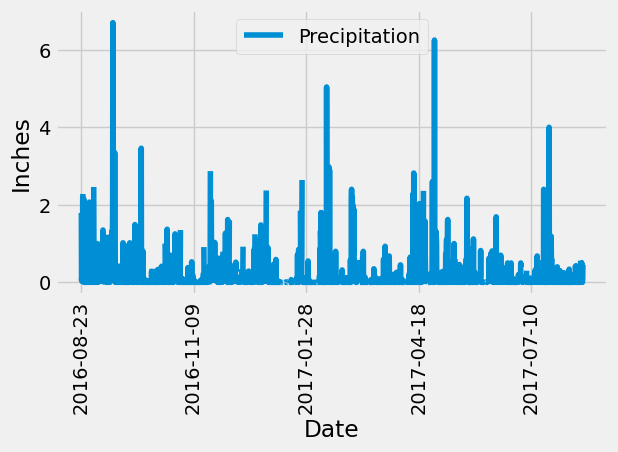

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.

one_year = most_recent - dt.timedelta(days=365)
one_year

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year).all()
print(len(query))
query

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query, columns=['date','precipitation'])

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.set_index('date', inplace=True)

ax = df.plot()
ax.tick_params(axis='x', labelrotation= 90)
ax.set_ylabel("Inches")
ax.set_xlabel("Date")
ax.legend(['Precipitation'])
plt.tight_layout()
plt.savefig("prcp.png")
plt.show()


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# inspect columns in the measurement table and station table

columns_m = inspector.get_columns('measurement')
print('columns and data types in tables')
print("-"*20)
print('measurement table')
print("-"*20)
for c in columns_m:
    print(c['name'], c['type'])

columns_s = inspector.get_columns('station')
print("-"*20)
print('station table')
print("-"*20)
for c in columns_s:
    print(c['name'], c['type'])



columns and data types in tables
--------------------
measurement table
--------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------
station table
--------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number of stations in the dataset

session.query(func.count(Station.id)).all()

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


station_counts = session.query((Measurement.station.distinct()),func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_id = session.query((Measurement.station.distinct()),func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).first()[0]

station_id

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).all()

stats

[(54.0, 85.0, 71.66378066378067)]

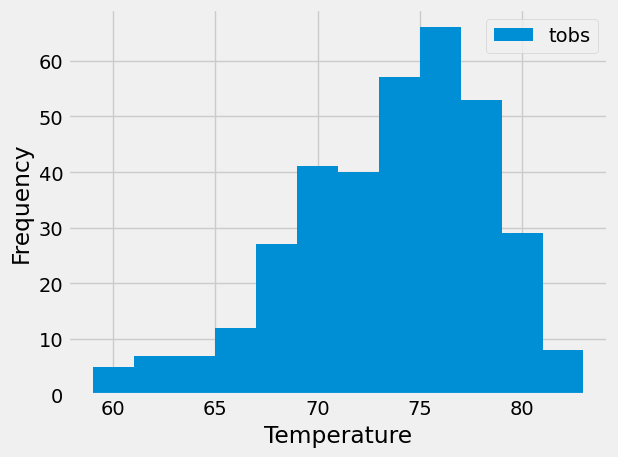

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= one_year).\
        filter(Measurement.station == station_id).all()

query

# create a df of query and plot histogram with bins=12

df = pd.DataFrame(query, columns=['date','temperature observations'])

ax = df.plot.hist(bins=12)
ax.set_ylabel("Frequency")
ax.set_xlabel("Temperature")
ax.legend(['tobs'])

plt.tight_layout()
plt.savefig("tobs.png")
plt.show()



# Close Session

In [22]:
# Close Session
session.close()